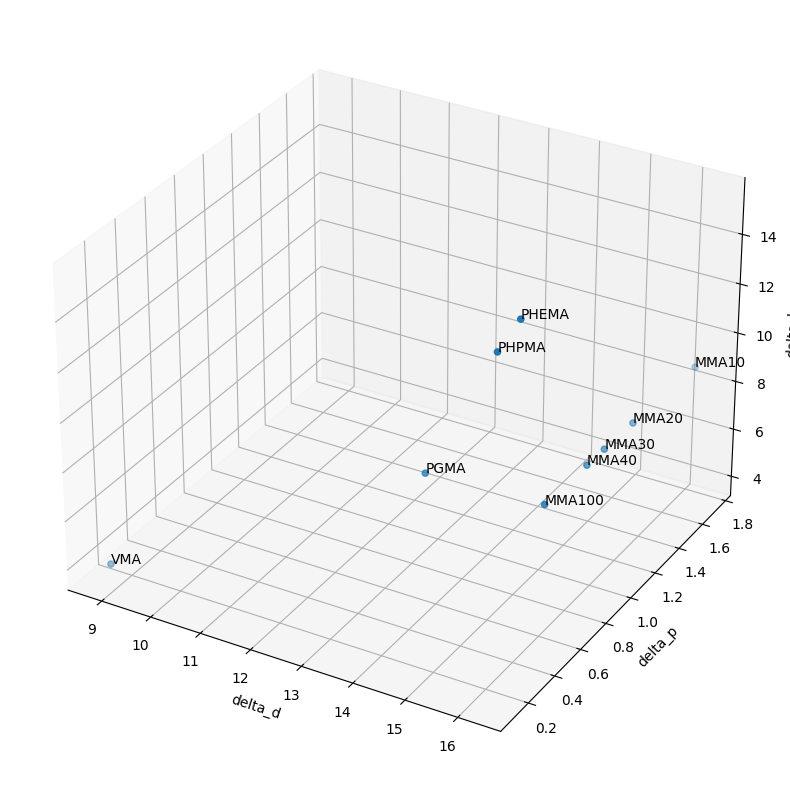

In [21]:
from modules import function as fc
import PySimpleGUI as sg
from rdkit import Chem
import pubchempy as pcp
import csv
import pandas as pd
import numpy as np

sg.theme("DarkBlack1")


#記述子名のリスト
properties = ["Tag","MW","Density","MolVolume","delta_d","delta_p","delta_h","sp"]
columns_name = properties

#過去データの取得、またはデータテーブルの初期化
try :
    #過去データの取得,DF化
    monomer_df = pd.read_csv("CSV/kreveren_sp_monomer.csv",encoding = "shift-jis")
    monomer_tag = monomer_df["Tag"].tolist()    
    polymer_df = pd.read_csv("CSV/kreveren_sp_polymer.csv",encoding = "shift-jis")

except:
    monomer_df = pd.read_csv("CSV/kreveren_sp_monomer.csv",encoding = "shift-jis")
    monomer_tag = monomer_df["Tag"].tolist()
    
    polymer_df = pd.DataFrame(columns = columns_name)
    polymer_df.to_csv("CSV/kreveren_sp_polymer.csv",index=False,encoding ="shift-jis")
    past_tag = pd.read_csv("CSV/kreveren_sp_polymer.csv")["Tag"].tolist()

#全体のレイアウト
layout = [[sg.Text('Krevelen SP', font=('Constantia',20,"bold"))],
          [sg.Frame("Main",[[sg.Text("タグ",size=(10, 1)),
                             sg.Input(size=(40, 1),key = "Tag" ,
                                      text_color='black',
                                      background_color='honeydew')],      
                            [sg.Button("実行",size=(10,1)),
                             sg.Button("記録",size=(10,1)),
                             sg.Button("削除",size=(10,1)),
                             sg.Button("SP空間",size=(10,1)),
                            ],

                            [sg.Text('_'  * 50)], #横線区切り
                            [sg.Text('原料品名',size=(20,1)),sg.Text('仕込み量',size=(20,1))],
                            [sg.Column(layout=[
                                [sg.Combo(monomer_tag, 
                                          size=(20, 1),
                                          key= f'material_{n}',
                                          text_color='black',
                                          background_color='honeydew'
                                                  ),
                                          sg.Input("0", 
                                                   size=(20, 1), 
                                                   key=f"feed_{n}",
                                                   text_color='black',
                                                   background_color='honeydew'
                                                  )
                                      ] for n in range(10)],
                                         
                                  size=(400, 280)  # 列全体のサイズ
                                  )],
                            [sg.Text("MW (g/mol)",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "MW")],
                            [sg.Text("density(g/cm3)",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "dens")],
                            [sg.Text("MolVolume",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "MolVolume")],
                            [sg.Text("delta_d",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "delta_d")],
                            [sg.Text("delta_p",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "delta_p")],
                            [sg.Text("delta_h",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "delta_h")],
                            [sg.Text("sp",size=(10, 1)),
                             sg.Text("",size=(60, 1),key = "sp")],
                            
                           ]),
           sg.Frame("記録データ表",
                    [[sg.Table(headings=polymer_df.columns.to_list(),
                               values=polymer_df.to_numpy().tolist(),
                               auto_size_columns=False,
                               col_widths=[10] * len(polymer_df.columns),
                               key="output_table",
                               display_row_numbers=True,
                               vertical_scroll_only = False,
                               num_rows=min(30, 30))]],
                    vertical_alignment="top")]]

# モニターの解像度を取得
screen_width, screen_height = sg.Window.get_screen_size()

# ウィンドウのサイズをモニターの全画面に設定
window_size = (screen_width, screen_height)

# ウインドウの出現位置を指定
win_location = (0, 0)
window = sg.Window("Polymer", 
                   layout, 
                   size=window_size,
                   resizable=True,
                   location=win_location)

while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED:
        break
    if event == "実行":

        #出力用dict
        composition ={}
        
        for i in range(10):
            material_name = values[f"material_{i}"]
            
            #materialnameに入力されている場合のみデータ参照可能
            if material_name != "":  
                #compositionに組成情報を記録
                composition[material_name]=int(values[f"feed_{i}"])

        
        #組成モノマー名のリストをforでループし、monomer_dfからSMILESを取得

        #ポリマー分子体積はモノマーの分子体積の和として近似
        #モノマー1mol当たり12cmの体積収縮を加味するが、結合数はモノマー数-1なので初期値12として補正する
        polymer_vol = 13.5
        feed_monomers =[]
        for monomer_name in list(composition.keys()):
            id = monomer_df.loc[monomer_df["Tag"]==monomer_name].index[0]
            smiles = monomer_df.loc[id]["SMILES"]
            vol = monomer_df.loc[id]["MolVolume"]
            feed_monomers = [smiles]*int(composition[monomer_name]) + feed_monomers
            #モノマー1mol当たり12cmの体積収縮を加味する
            polymer_vol = (vol-13.5)*int(composition[monomer_name]) + polymer_vol

        result = "".join(feed_monomers)
        if len(result) > 4000:
            sg.popup("仕込み量が多すぎます")
            break
            

        
        #モノマーを重合する関数を呼び出し
        from modules import reactions as rx
        polymer =  rx.Polymerization(feed_monomers)
        
        #重合生成フラグメントをそれぞれVanKrevelen法のSP計算実行
        from modules import function
        

        params = function.Krevelen_sp(polymer,polymer_vol)
        mw = params.mw
        vol = params.vol 
        dens = mw/vol
        delta_d = params.results["delta_d"]
        delta_p = params.results["delta_p"] 
        delta_h = params.results["delta_h"]
        sp =  params.results["delta_total"]

        #各パラメータの更新
        window["MW"].update(f"{mw}")
        window["dens"].update(f"{dens}")
        window["MolVolume"].update(f"{vol}")
        window["delta_d"].update(f"{delta_d}")
        window["delta_p"].update(f"{delta_p}")
        window["delta_h"].update(f"{delta_h}")
        window["sp"].update(f"{sp}")

            
    if event == "記録":

        #追加データ行の作製
        if values["Tag"] !="":
            tag = values["Tag"] #TagがあるときはTag名に
        else:
            tag = "None"
        new_row = [tag, mw,dens,vol,delta_d,delta_p,delta_h,sp]
        new_row_df = pd.DataFrame([new_row],columns = columns_name)


        #既存データの場合
        if tag in polymer_df["Tag"].tolist():
            #読み取ったデータを該当の行に更新
            #行の初期化
            for elem in list(polymer_df.columns)[1:]:
                polymer_df.loc[polymer_df["Tag"] ==tag, elem] =0
            #要素の更新
            for elem in list(polymer_df.columns)[1:]:
                polymer_df.loc[polymer_df["Tag"] ==tag, elem] = new_row_df.iloc[0][elem]
        
        #新規データの場合
        else:    
            polymer_df = pd.concat([polymer_df,new_row_df])
            #Windowテーブルの更新
        window["output_table"].update(polymer_df.to_numpy().tolist())
        polymer_df.to_csv("CSV/kreveren_sp_polymer.csv",index=False,encoding ="shift-jis")
        
    if event == "削除":
        delete_Tag = values["Tag"]
        if delete_Tag in polymer_df["Tag"].to_list(): 
            polymer_df = polymer_df[polymer_df["Tag"] != delete_Tag]
            polymer_df = polymer_df[polymer_df["Tag"] != False ]
            past_tag2 = polymer_df["Tag"].to_numpy()
            window["output_table"].update(polymer_df.to_numpy().tolist())
            polymer_df.to_csv("CSV/kreveren_sp_polymer.csv",index=False,encoding ="shift-jis")

            
    if event == "SP空間":
        
        tag = polymer_df["Tag"].tolist()
        x = polymer_df["delta_d"].tolist()
        y = polymer_df["delta_p"].tolist()
        z = polymer_df["delta_h"].tolist()

        
        fc.scatter3d(x,y,z,tag)
    
window.close()